# Inference Example

This notebook illustrates how the inference algorithm can be used to estimate outbreak origins.

In [10]:
import pandas as pd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 150
import matplotlib.pyplot as plt


## Load input trajectories

First we load trajectories of 1000 individuals, generated from a dEPR model for the area of Berlin.


The trajectory data consist of the columns:
 - ind: An identifier of the individual
 - t: The timestamp of observations
 - lon/lat: The location of the observations

In [2]:
traj = pd.read_csv('../data/sample_trajectories_N1000.csv')
traj.head()

,ind,t,lon,lat
0,0,0.0000,13.4774,52.5021
1,0,6.4538,13.4923,52.4909
2,0,7.0046,13.4892,52.4913
3,0,8.9135,13.4511,52.5059
4,0,10.7044,13.4724,52.4925


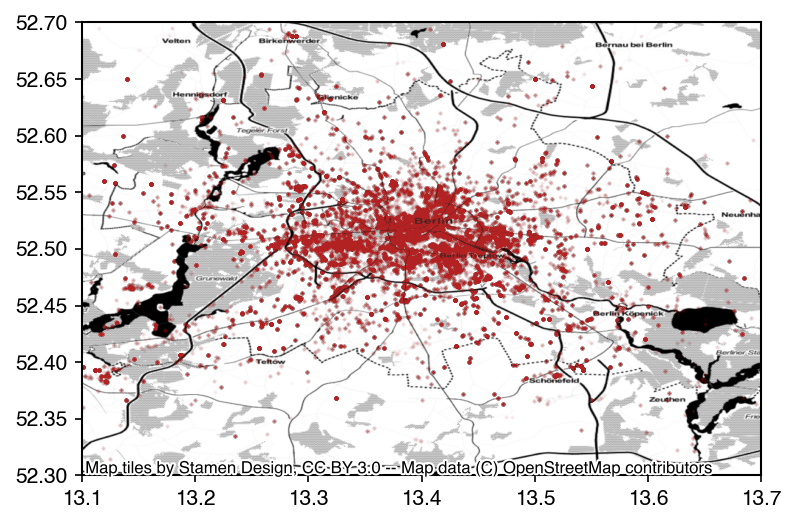

In [11]:
import contextily as cx
fig, ax = plt.subplots()
ax.scatter(traj['lon'], traj['lat'], s=1, color='firebrick', alpha=0.01)
ax.set_xlim([13.1,13.7])
ax.set_ylim([52.3,52.7])
cx.add_basemap(ax, crs="EPSG:4326", source=cx.providers.Stamen.Toner)
plt.show()

## Preparing a sample of individual trajectories

We prepare a sample of 4 trajectories which we will pass to the inference method.

In [12]:
sample_individuals = [0,1,3,4]

sample_trajectories = traj.loc[traj['ind'].isin(sample_individuals)]

 As one can see, the individuals generally move in distinct "neighborhoods", centered around their home location.

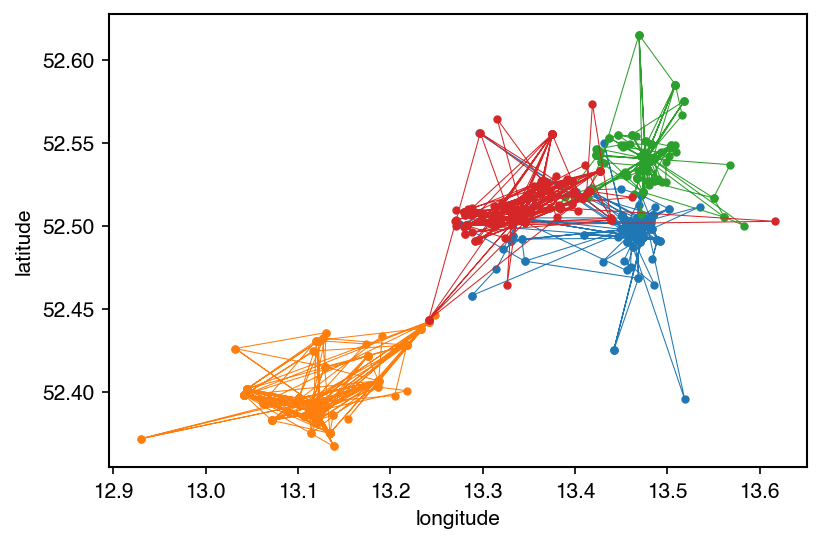

In [13]:
from outbreak.util import plot_trajectories
plot_trajectories(sample_trajectories)

We limit the sample to a short section from the full tractories, representing the simulated movements over 100 hours.

We can actually see that a meeting between the blue and red individual occurs, where blue meets the red individual at its home location.


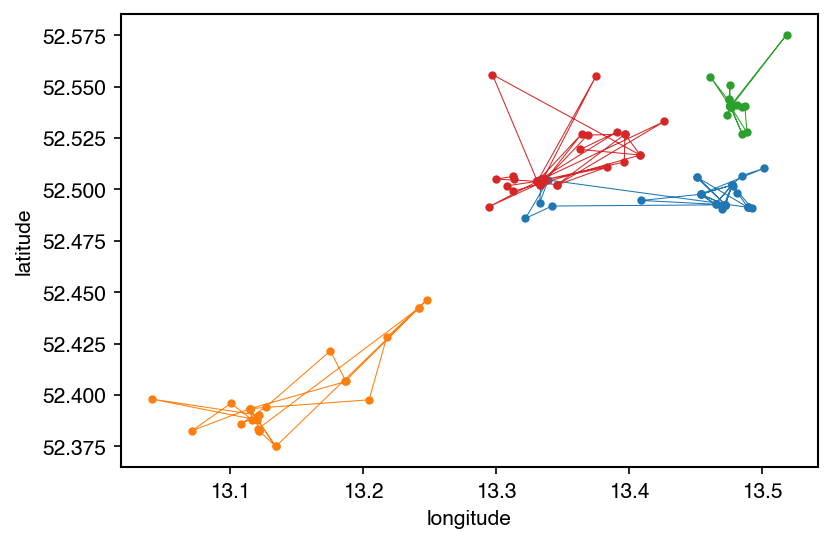

In [14]:
sample_trajectories = sample_trajectories.loc[sample_trajectories['t'] < 100]
plot_trajectories(sample_trajectories)

## Inference Method

We now initialize the inference method, using its standard parameters, and apply it to the sample trajectories of the 4 individuals above.

The inference method looks for co-locations among the individuals. In the example here,the method correctly identifies the co-location of the blue and red individuals as the most likely outbreak origin.

In [24]:
from outbreak import Inference

inference = Inference()

origins = inference.find_outbreak_origins(sample_trajectories)
origins.head()

,loc_id,lat,lon,score,time
0,0,52.50445,13.33255,0.463122,1970-01-04 15:30:00
1,1,52.50345,13.33345,0.458717,1970-01-04 14:37:30
2,2,52.48590,13.32210,0.250001,1970-01-04 11:00:00
3,3,52.50390,13.33110,0.250001,1970-01-04 11:00:00
9,9,52.49290,13.46500,0.250000,1970-01-02 16:58:45


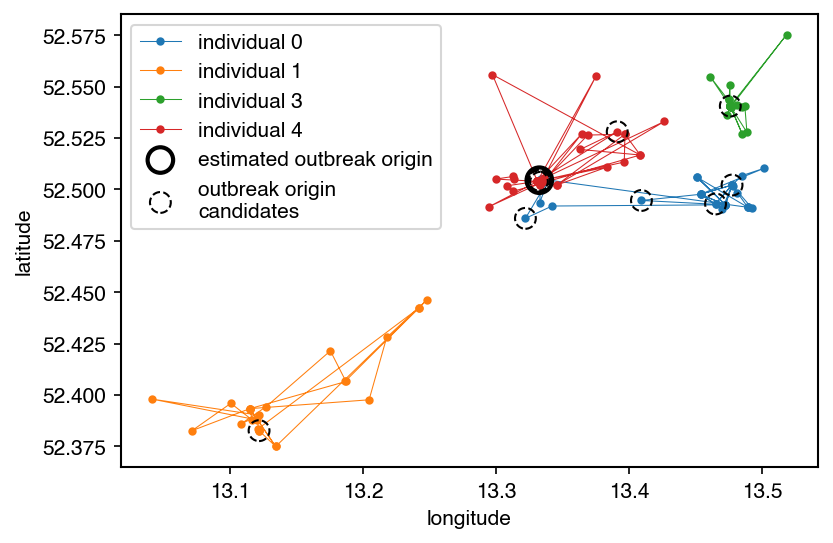

In [17]:
from outbreak.util import plot_result
plot_result(sample_trajectories, origins, n_origins=10)
plt.show()

## Effect of the gaussian variance on the inference

The variance *sigma* of the gaussian distribution used to represent the position of each individual is the main parameter of the inference algorithm. It is given in units if km to the algorithm.

The variance should be adjusted according to the spatial scale on which the algorithm is used

The below plots show the effect of different values *sigma*.

For small values, the inferred locations are close to the positions of the individuals. In the example, the meeting of the blue and red individuals are deemed the most likely outbreak origin.

For higher values, more distant individuals are deemed to be at the same location. In the example, the general area between the blue, red and green individuals becomes the likely outbreak location.

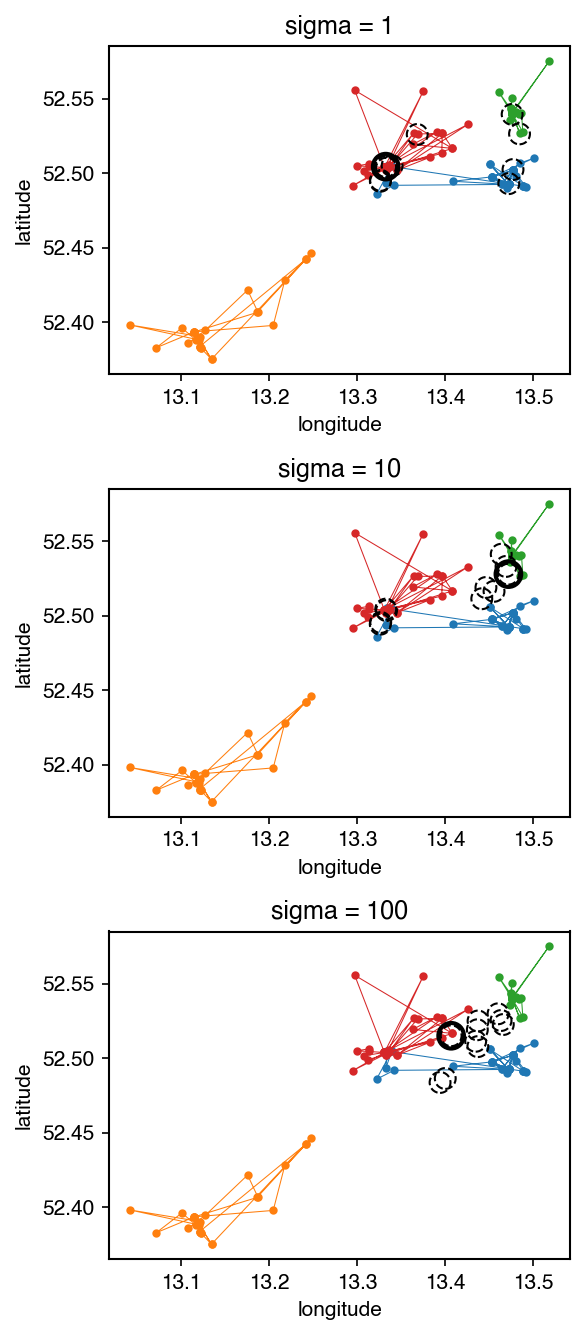

In [25]:
sigmas = [1,10,100]
fig, axes = plt.subplots(3,1, figsize=(4,9))

for sigma, ax in zip(sigmas, axes):

    inference = Inference(GAUSS_SIGMA=sigma, MAX_NEIGHBORHOOD_SIZE_KM=1)
    origins = inference.find_outbreak_origins(sample_trajectories)
    plot_result(sample_trajectories, origins, n_origins=10, ax=ax, legend=False)
    ax.set_title('sigma = {}'.format(sigma))
plt.tight_layout()
plt.show()
